In [2]:
import pymysql
import pymysql.cursors
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statistics

In [3]:
user_vars = {}
with open("user_variables.txt") as f:
    for line in f:
        key, value = line.partition("=")[::2]
        user_vars[key.rstrip()] = value.rstrip()

#Set up a database connection:
connection = pymysql.connect(host='localhost',
                             user=user_vars['db_username'],
                             password=user_vars['db_password'],
                             db=user_vars['db_database'],
                             charset='utf8',
                             cursorclass=pymysql.cursors.DictCursor)

In [21]:
raceResultsByGridPosition = {}

with connection.cursor() as cursor:
    for year in range(2003, 2021):
        sql = "SELECT `raceId`, `round`, `circuitId`, `name` FROM `races` WHERE `year`=%s"
        cursor.execute(sql, year)
        result = cursor.fetchall()

        for x in result:
            circuitId = x.get('circuitId')        
            sql = "SELECT `driverId`, `constructorId`, `position`, `grid` FROM `results` WHERE `raceId`=%s"
            cursor.execute(sql, x.get('raceId'))
            result = cursor.fetchall()

            if result:
                result.sort(key=lambda result: (result['position'] is None, result['position']))
                for row in result:
                    if row['position']:
                        if row['grid'] not in raceResultsByGridPosition and row['grid'] > 0:
                            raceResultsByGridPosition[row['grid']] = []
                        if row['grid'] > 0:
                            raceResultsByGridPosition[row['grid']].append(row['position'])

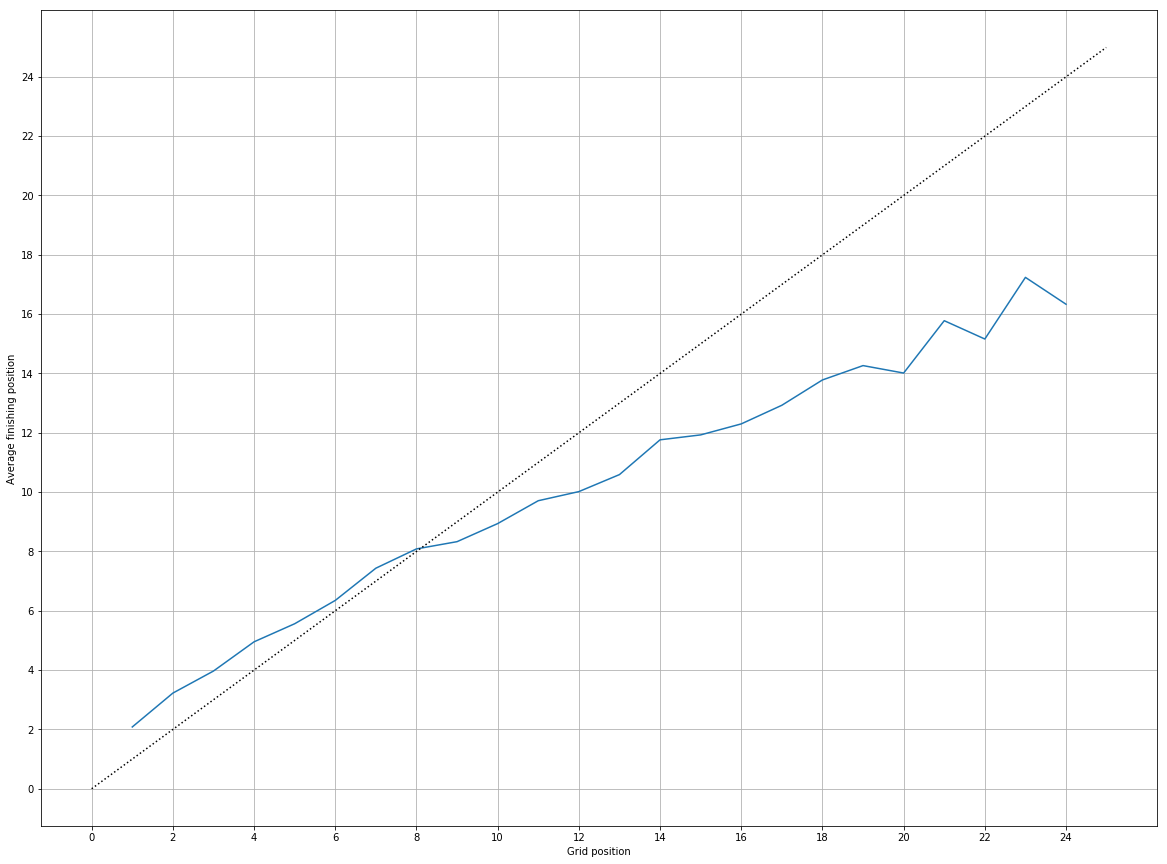

In [22]:
keys = sorted(raceResultsByGridPosition.keys())
values = [statistics.mean(raceResultsByGridPosition[x]) for x in keys]

fig, ax = plt.subplots(figsize=(20,15))
ax.grid(True, which='both')

major_ticks = np.arange(0, 25, 2)

ax.set_xticks(major_ticks)
ax.set_yticks(major_ticks)

plt.xlabel('Grid position')
plt.ylabel('Average finishing position')

ax.plot(keys, values)
ax.plot(np.arange(0, 25, 0.01), np.arange(0, 25, 0.01), color='black', linestyle=':')